In [1]:
# Step 1: Upload the file
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Upload the dataset
uploaded = files.upload()  # This will prompt you to upload the TXT file
# Load the data into a DataFrame
file_name = list(uploaded.keys())[0]
data = pd.read_csv(
    file_name,
    delim_whitespace=True,  # or sep="\t", depending on your file
    header=0,               # Adjust if your header is on a different row
    skiprows=0              # Adjust if needed
)

Saving Normalized_WT5.txt to Normalized_WT5.txt


<ipython-input-1-fd73ed387e22>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


Cleaned Column Names: Index(['Sequence No.', 'V', 'D', 'air density', 'Humidity', 'I', 'S_a', 'S_b',
       'y (% relative to rated power)'],
      dtype='object')


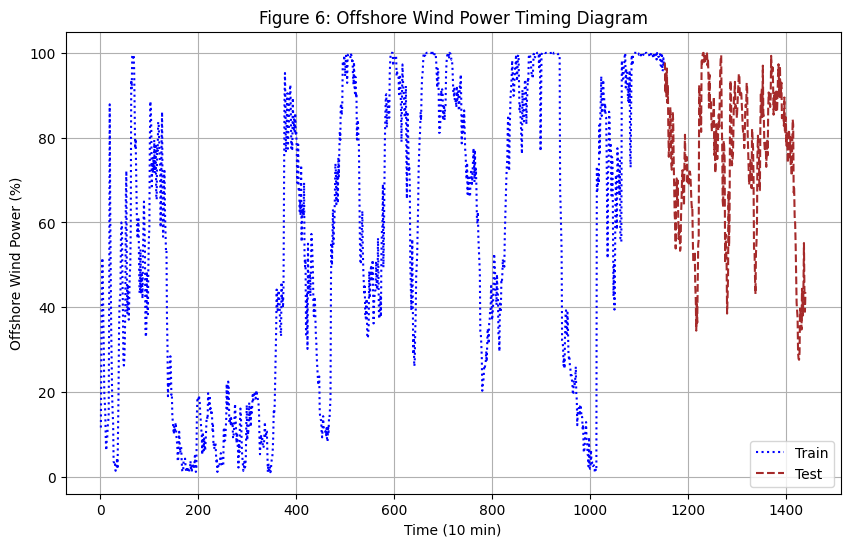

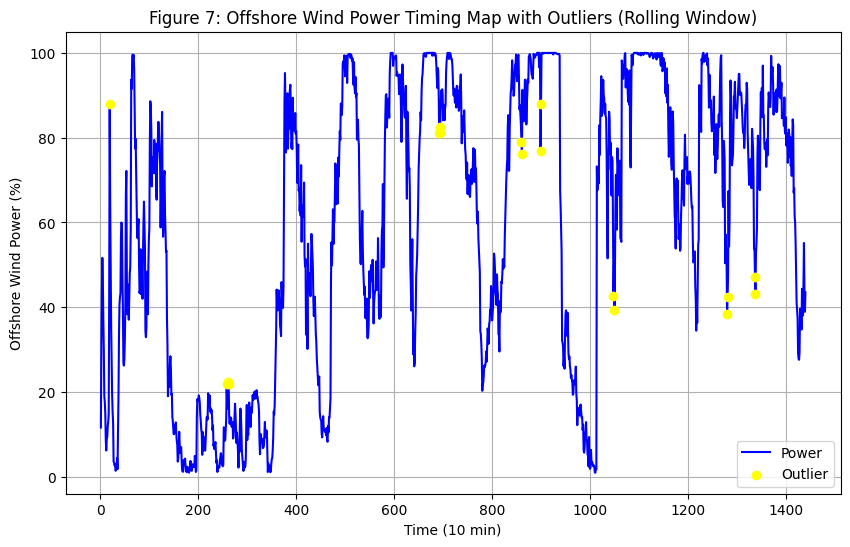

In [2]:
# Step 2: Select the first 1440 rows and extract relevant columns
data = data.iloc[:1440]  # Select only the first 1440 rows
time = np.arange(1, 1441)  # Generate time steps (1 to 1440)
# Clean column names
data.columns = data.columns.str.strip()  # Remove leading and trailing whitespaces
print("Cleaned Column Names:", data.columns)  # Check cleaned column names

# Access the 'y' column
power = data["y (% relative to rated power)"]  # Ensure this matches the cleaned column name


# Step 3: Plot Figure 6 - Offshore Wind Power Timing Diagram
train_size = int(0.8 * len(data))  # 80% train, 20% test split
train_power = power[:train_size]
test_power = power[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(time[:train_size], train_power, label="Train", color="blue", linestyle="dotted")
plt.plot(time[train_size:], test_power, label="Test", color="brown", linestyle="dashed")
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.title("Figure 6: Offshore Wind Power Timing Diagram")
plt.grid()
plt.show()
import numpy as np

window_size = 48
rolling_mean = []
rolling_std = []  # or rolling variance, depending on the exact interpretation

for i in range(len(power)):
    # Define the window boundaries (e.g., 48 points around i)
    # We'll do a simple centered window:
    start = max(0, i - window_size//2)
    end = min(len(power), i + window_size//2)
    # start = max(0, i)
    # end = min(len(power), i + window_size)

    window_data = power[start:end]

    # Compute mean & std (or variance)
    mu = window_data.mean()
    sigma = window_data.std()  # std is the sqrt of variance

    # Keep track if needed
    rolling_mean.append(mu)
    rolling_std.append(sigma)

# Now define outliers if data[i] is beyond mean ± 2*sigma in its window
outliers_mask = []
for i in range(len(power)):
    if power[i] < rolling_mean[i] - 2 * rolling_std[i] or power[i] > rolling_mean[i] + 2 * rolling_std[i]:
        outliers_mask.append(True)
    else:
        outliers_mask.append(False)

outliers_mask = np.array(outliers_mask)

# # Step 4: Outlier Detection Using Rolling Window (Paper's Method)

# Plot the power data with outliers highlighted (Figure 7)
plt.figure(figsize=(10, 6))
plt.plot(time, power, label="Power", color="blue")
plt.scatter(time[outliers_mask], power[outliers_mask], color="yellow", label="Outlier", zorder=5)
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.title("Figure 7: Offshore Wind Power Timing Map with Outliers (Rolling Window)")
plt.grid()
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

class Autoencoder:
    def __init__(self, window_size, latent_dim):
        """
        Initialize the Autoencoder class.
        Args:
            window_size (int): Number of time steps in each sequence (input dimension).
            latent_dim (int): Size of the latent space (latent dimension).
        """
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
    def build(self):
        """
        Build the Autoencoder, Encoder, and Decoder models.
        """
        # Encoder
        input_layer = Input(shape=(self.window_size, 1), name="Input_Layer")
        flattened = Flatten(name="Flatten_Layer")(input_layer)  # Flatten time-series input
        hidden1 = Dense(128, activation='relu', name="Hidden_Layer_1")(flattened)
        hidden2 = Dense(64, activation='relu', name="Hidden_Layer_2")(hidden1)
        latent_layer = Dense(self.latent_dim, activation='relu', name="Latent_Layer")(hidden2)
        # Decoder
        hidden3 = Dense(64, activation='relu', name="Decoder_Layer_1")(latent_layer)
        hidden4 = Dense(128, activation='relu', name="Decoder_Layer_2")(hidden3)
        output_flat = Dense(self.window_size, activation='linear', name="Output_Flat")(hidden4)
        output_layer = Reshape((self.window_size, 1), name="Output_Reshape")(output_flat)
        # Autoencoder Model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
        # Encoder Model
        self.encoder = Model(inputs=input_layer, outputs=latent_layer, name="Encoder")

        # Decoder Model
        encoded_input = Input(shape=(self.latent_dim,), name="Encoded_Input")
        decoder_hidden1 = self.autoencoder.get_layer("Decoder_Layer_1")(encoded_input)
        decoder_hidden2 = self.autoencoder.get_layer("Decoder_Layer_2")(decoder_hidden1)
        decoder_flat = self.autoencoder.get_layer("Output_Flat")(decoder_hidden2)
        decoder_output = self.autoencoder.get_layer("Output_Reshape")(decoder_flat)
        self.decoder = Model(inputs=encoded_input, outputs=decoder_output, name="Decoder")

    def compile(self, optimizer='adam', loss='mse'):
        """
        Compile the Autoencoder model.

        Args:
            optimizer (str): Optimizer for training (default: 'adam').
            loss (str): Loss function to minimize (default: 'mse').
        """
        if not self.autoencoder:
            raise ValueError("The model must be built before compiling.")
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    def train(self, x_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.1):
        """
        Train the Autoencoder model.
        Args:
            x_train (np.array): Training input data (e.g., sequences of time steps).
            epochs (int): Number of epochs to train (default: 100).
            batch_size (int): Batch size for training (default: 16).
            shuffle (bool): Whether to shuffle the training data (default: True).
            validation_split (float): Fraction of data for validation (default: 0.1).

        Returns:
            History object: Contains training history.
        """
        if not self.autoencoder:
            raise ValueError("The model must be built and compiled before training.")
        return self.autoencoder.fit(
            x_train, x_train,  # Input and target are the same for autoencoders
            epochs=epochs,
            batch_size=batch_size,
            shuffle=shuffle,
            validation_split=validation_split
        )
    def summary(self):
        """
        Print the summary of the Autoencoder model.
        """
        if not self.autoencoder:
            raise ValueError("The model must be built before accessing the summary.")
        self.autoencoder.summary()


In [4]:
# Parameters
window_size = 144  # Time steps in each sequence
latent_dim = 16   # Size of the latent space

def create_sliding_windows(data, window_size):
    """
    Create sliding windows from the data.

    Args:
        data (np.array): Input data array (1D time-series).
        window_size (int): Number of time steps in each window.

    Returns:
        np.array: Array of sliding windows with shape (num_samples, window_size, 1).
    """
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows).reshape(-1, window_size, 1)

# Simulated input data (replace with your actual y column values)
sliding_windows = create_sliding_windows(power, window_size)

# Create and build the Autoencoder
autoencoder_model = Autoencoder(window_size, latent_dim)
autoencoder_model.build()

# Compile the Autoencoder
autoencoder_model.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = autoencoder_model.train(
    x_train=sliding_windows,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_split=0.1
)

# Display the model summary
autoencoder_model.summary()

# Use the trained Autoencoder to "denoise" (reconstruct) the data
data_denoised = autoencoder_model.autoencoder.predict(sliding_windows)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 2031.4597 - val_loss: 225.3629
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 347.0352 - val_loss: 198.1127
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190.5672 - val_loss: 178.3410
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.4977 - val_loss: 160.2075
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127.6583 - val_loss: 144.5231
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.6757 - val_loss: 140.7073
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.2308 - val_loss: 135.8991
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.6825 - val_loss: 120.5133
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.4477 - val_loss: 114.6341
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.0166 - val_loss: 111.8302
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74.8513 - val_loss: 106.2608
Epoch 12/100
73/73 ━━

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 144, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_1 (Dense)               │ (None, 128)                 │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Latent_Layer (Dense)                 │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Layer_1 (Dense)              │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Layer_2 (Dense)              │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Flat (Dense)                  │ (None, 144)                 │          18,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Reshape (Reshape)             │ (None, 144, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,522 (654.39 KB)

 Trainable params: 55,840 (218.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 111,682 (436.26 KB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


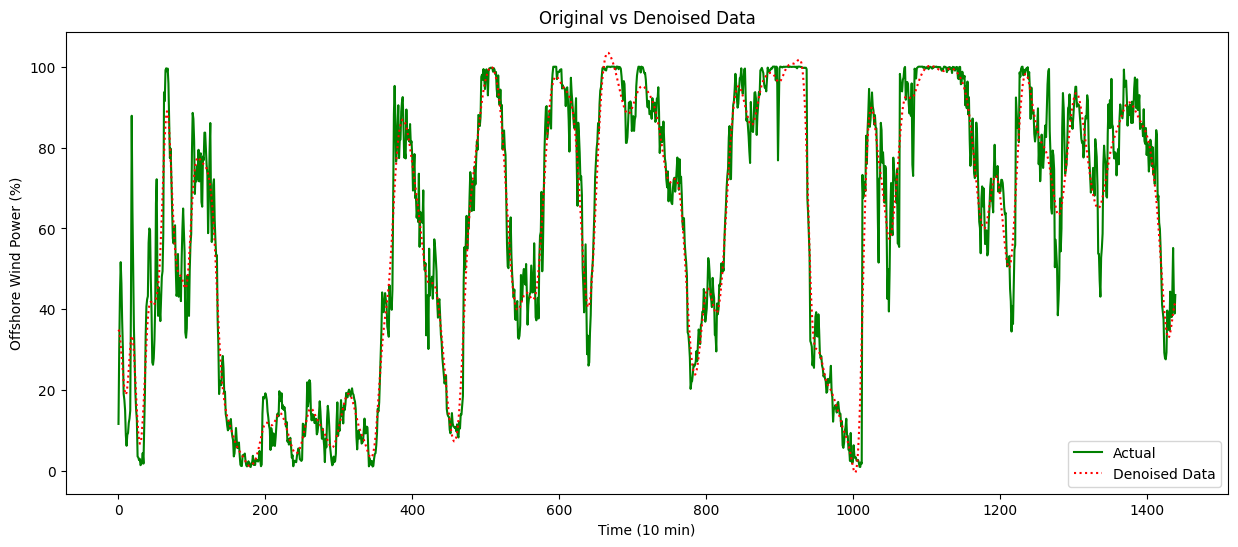

In [5]:
# Reconstruct the full denoised sequence from sliding windows
denoised_full = np.zeros((1440,))
count = np.zeros((1440,))  # Track the number of contributions for each time step

# Aggregate overlapping windows
for i in range(len(data_denoised)):
    denoised_full[i:i + window_size] += data_denoised[i].flatten()
    count[i:i + window_size] += 1

# Average overlapping regions
denoised_full /= count

# Plot original vs reconstructed data
plt.figure(figsize=(15, 6))
plt.plot(power, label="Actual", color="green")
plt.plot(denoised_full, label="Denoised Data", color="red", linestyle="dotted")
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.title("Original vs Denoised Data")
plt.legend()
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
#  Step 1: Reconstruct & Denoise
# ------------------------------
#  Assume you have a trained autoencoder and raw data "data" of length 1440.

# PARAMETERS
window_size = 144  # or any window size used for the autoencoder
# 'data' should be your raw offshore wind power array of shape (1440,).

# EXAMPLE: Suppose you have an autoencoder instance named 'autoenc'
# and a function get_autoencoder_windows() that creates overlapping windows
# for the autoencoder. Then you get 'data_denoised' from model predictions.

# For demonstration, let's assume you've already obtained 'data_denoised'
# from the autoencoder as an array of shape (num_windows, window_size, 1).

# --- AGGREGATE OVERLAPPING WINDOWS TO RECONSTRUCT FULL SERIES ---
# "data_denoised" is the autoencoder output for each overlapping window.
# We combine them to get a single 1D "denoised_full" of length 1440.

# Replace 'data' with 'denoised_full' if you want to use the denoised version onward
data_denoised_series = denoised_full

# ---------------------------------------------------------
#  Step 2: Partition Denoised Data into Train and Test Sets
# ---------------------------------------------------------
train_ratio = 0.8
train_size = int(train_ratio * len(data_denoised_series))
data_train = data_denoised_series[:train_size]
data_test = data_denoised_series[train_size:]

print(f"Train size: {len(data_train)}, Test size: {len(data_test)}")

# -----------------------------------------------
#  Step 3: Normalize the Training & Test Subsets
# -----------------------------------------------
# We'll reshape to (num_samples, 1) to fit MinMaxScaler properly
data_train_2d = data_train.reshape(-1, 1)
data_test_2d = data_test.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train_2d)
data_test_scaled = scaler.transform(data_test_2d)

# Reshape them back to 1D if convenient, or keep 2D for sliding windows
data_train_scaled = data_train_scaled.flatten()
data_test_scaled = data_test_scaled.flatten()

print("After Normalization:")
print("Train scaled range:", data_train_scaled.min(), data_train_scaled.max())
print("Test scaled range:", data_test_scaled.min(), data_test_scaled.max())

# -------------------------------------------------------------------
#  Step 4: Transform into Features (X) & Response (Y) via Sliding Window
# -------------------------------------------------------------------
# We define a function to create sliding windows for multi-step forecasting.
def create_sliding_windows(series, window_size, forecast_horizon):
    """
    Create input (X) and output (y) arrays from a 1D time-series using sliding windows.

    Args:
        series (np.array): 1D array of scaled data.
        window_size (int): Number of time steps for each input window (X).
        forecast_horizon (int): How many steps ahead to predict (y).

    Returns:
        (X, y): np.arrays of shapes (num_samples, window_size) and (num_samples, forecast_horizon)
    """
    X, y = [], []
    for i in range(len(series) - window_size - forecast_horizon + 1):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size : i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Example parameters
sliding_window_size = 144  # e.g. 144 time steps (maybe 1 day)
forecast_horizon = 1       # e.g 1 step for single step problem

X_train, y_train = create_sliding_windows(data_train_scaled, sliding_window_size, forecast_horizon)
X_test, y_test = create_sliding_windows(data_test_scaled, sliding_window_size, forecast_horizon)

print("X_train shape:", X_train.shape)  # (samples, sliding_window_size)
print("y_train shape:", y_train.shape)  # (samples, forecast_horizon)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Train size: 1152, Test size: 288
After Normalization:
Train scaled range: 0.0 1.0
Test scaled range: 0.3212723956931526 0.9498849063935976
X_train shape: (1008, 144)
y_train shape: (1008, 1)
X_test shape: (144, 144)
y_test shape: (144, 1)


In [27]:
# Step 5: Dataset Preparation

import torch
from torch.utils.data import Dataset, DataLoader
import math

class WindPowerDataset(Dataset):
    def __init__(self, X, y):
        """
        Initializes the dataset with input features and targets.

        Args:
            X (np.array): Input features of shape (num_samples, window_size).
            y (np.array): Targets of shape (num_samples,).
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets
train_dataset = WindPowerDataset(X_train, y_train.flatten())
print(X_train.shape)
test_dataset = WindPowerDataset(X_test, y_test.flatten())

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


(1008, 144)
Number of training samples: 1008
Number of testing samples: 144


In [23]:
# Step 6: Model Definitions

import torch.nn as nn

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Implements the sinusoidal positional encoding.

        Args:
            d_model (int): Embedding dimension.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()

        # Create constant 'pe' matrix with values dependent on
        # pos and i
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Tensor of shape (seq_len, batch_size, d_model)

        Returns:
            torch.Tensor: Tensor with positional encoding added.
        """
        x = x + self.pe[:x.size(0), :]
        return x

# Transformer Model with Positional Encoding
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, max_len=144):
        """
        Transformer model for single-step prediction with positional encoding.

        Args:
            input_dim (int): Number of input features per time step.
            d_model (int): Dimension of the embedding.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network.
            max_len (int): Maximum sequence length.
        """
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Forward pass of the Transformer model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        # Reshape for Transformer: (batch_size, window_size, input_dim)
        x = x.unsqueeze(-1)  # (batch_size, window_size, 1)
        x = self.embedding(x)  # (batch_size, window_size, d_model)
        x = x.permute(1, 0, 2)  # (window_size, batch_size, d_model)
        x = self.pos_encoder(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # (window_size, batch_size, d_model)
        x = x[-1, :, :]  # (batch_size, d_model)
        x = self.fc_out(x)  # (batch_size, 1)
        return x.squeeze()

# Basic RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        """
        Basic RNN model for single-step prediction.

        Args:
            input_dim (int): Number of input features per time step.
            hidden_dim (int): Number of hidden units.
            num_layers (int): Number of RNN layers.
        """
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass of the Basic RNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        x = x.unsqueeze(-1)  # (batch_size, window_size, 1)
        rnn_out, _ = self.rnn(x)  # (batch_size, window_size, hidden_dim)
        rnn_out = rnn_out[:, -1, :]  # (batch_size, hidden_dim)
        x = self.fc_out(rnn_out)  # (batch_size, 1)
        return x.squeeze()


# MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[64, 32]):
        """
        MLP model for single-step prediction.

        Args:
            input_dim (int): Number of input features (flattened).
            hidden_sizes (list): List containing the sizes of hidden layers.
        """
        super(MLPModel, self).__init__()
        layers = []
        last_size = input_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden_size))
            layers.append(nn.ReLU())
            last_size = hidden_size
        layers.append(nn.Linear(last_size, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the MLP model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        return self.network(x).squeeze()


In [9]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CustomHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        """
        Initializes the CustomHuberLoss module.

        Args:
            delta (float): Threshold for switching between quadratic and linear loss. Default is 1.0.
        """
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        """
        Computes the Huber loss.

        Args:
            y_pred (torch.Tensor): Predicted values. Shape: (batch_size,)
            y_true (torch.Tensor): True values. Shape: (batch_size,)

        Returns:
            torch.Tensor: Average Huber loss.
        """
        error = y_pred - y_true
        abs_error = torch.abs(error)
        loss = torch.where(
            abs_error <= self.delta,
            0.5 * error**2,
            self.delta * (abs_error - 0.5 * self.delta)
        )
        return loss.mean()



# Step 7: Define Loss Functions

# Define loss functions with CustomHuberLoss
loss_functions = {
    'MSE': nn.MSELoss(),
    'Huber': CustomHuberLoss(delta=1.0)
}
# Training parameters
num_epochs = 50
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, and MAPE metrics.

    Args:
        y_true (np.array): Actual target values.
        y_pred (np.array): Predicted target values.

    Returns:
        tuple: RMSE, MAE, MAPE
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # To avoid division by zero, add a small epsilon where y_true is zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return rmse, mae, mape

# Initialize results storage
results = []

# Define model classes mapping
model_classes = {
    'Transformer': TransformerModel,
    'RNN': RNNModel,           # Use simple RNN
    'MLP': MLPModel
}
# Define the number of input features per time step
num_features = 1  # Univariate time-series (only wind power)

# Iterate through each model and loss function combination
for model_name, model_class in model_classes.items():
    for loss_name, criterion in loss_functions.items():
        print(f"\nTraining {model_name} with {loss_name} loss")

        # Instantiate a new model for each combination to ensure fresh weights
        if model_name == 'Transformer':
            model = TransformerModel(
                input_dim=num_features,    # Updated parameter
                d_model=64,
                nhead=4,  # As per paper's specification
                num_layers=3,
                dim_feedforward=128,
                max_len=144
            ).to(device)
        elif model_name == 'RNN':
            model = RNNModel(
                input_dim=num_features,    # Updated parameter
                hidden_dim=64,
                num_layers=2
            ).to(device)
        elif model_name == 'MLP':
            model = MLPModel(
                input_dim=window_size,
                hidden_sizes=[64, 32]  # Adjusted as per paper
            ).to(device)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * batch_X.size(0)

            epoch_loss /= len(train_loader.dataset)

            # Print loss every 10 epochs and the first epoch
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Evaluation
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)

                # Convert tensors to NumPy arrays
                outputs_np = outputs.cpu().numpy()
                batch_y_np = batch_y.cpu().numpy()

                # Reshape for inverse transformation (assuming scaler expects 2D)
                outputs_np = outputs_np.reshape(-1, 1)
                batch_y_np = batch_y_np.reshape(-1, 1)

                # Inverse transform to original scale
                outputs_inv = scaler.inverse_transform(outputs_np).flatten()
                batch_y_inv = scaler.inverse_transform(batch_y_np).flatten()

                # Extend the lists
                all_preds.extend(outputs_inv)
                all_targets.extend(batch_y_inv)

        # Calculate metrics on original scale
        rmse, mae, mape = calculate_metrics(np.array(all_targets), np.array(all_preds))

        print(f"Evaluation Metrics for {model_name} with {loss_name} loss:")
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

        # Store results
        results.append({
            'Model': model_name,
            'Loss': loss_name,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        })




Training Transformer with MSE loss


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Loss: 0.0847
Epoch [10/50], Loss: 0.0020
Epoch [20/50], Loss: 0.0010
Epoch [30/50], Loss: 0.0006
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss: 0.0004
Evaluation Metrics for Transformer with MSE loss:
RMSE: 1.1785, MAE: 1.0332, MAPE: 1.48%

Training Transformer with Huber loss


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Loss: 0.0338
Epoch [10/50], Loss: 0.0013
Epoch [20/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0002
Evaluation Metrics for Transformer with Huber loss:
RMSE: 1.5402, MAE: 1.4603, MAPE: 2.05%

Training RNN with MSE loss
Epoch [1/50], Loss: 0.0910
Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0001
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Evaluation Metrics for RNN with MSE loss:
RMSE: 0.4803, MAE: 0.4282, MAPE: 0.66%

Training RNN with Huber loss
Epoch [1/50], Loss: 0.0424
Epoch [10/50], Loss: 0.0001
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Evaluation Metrics for RNN with Huber loss:
RMSE: 0.7070, MAE: 0.6414, MAPE: 0.94%

Training MLP with MSE loss
Epoch [1/50], Loss: 0.0981
Epoch [10/50], Loss: 0.0026
Epoch [20/50], Loss: 0.0011
Epoch [30/50], Loss: 0.0006
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss

In [11]:
# Step 9: Results Presentation

import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot the DataFrame to have Models as rows and Loss functions as columns for each metric
pivot_rmse = results_df.pivot(index='Model', columns='Loss', values='RMSE')
pivot_mae = results_df.pivot(index='Model', columns='Loss', values='MAE')
pivot_mape = results_df.pivot(index='Model', columns='Loss', values='MAPE')

# Combine the pivot tables
final_table = pd.concat([pivot_rmse, pivot_mae, pivot_mape], axis=1)
final_table.columns = ['RMSE (Huber)', 'RMSE (MSE)', 'MAE (Huber)', 'MAE (MSE)', 'MAPE (Huber)', 'MAPE (MSE)']

# Reorder columns for better readability
final_table = final_table[['RMSE (Huber)', 'RMSE (MSE)', 'MAE (Huber)', 'MAE (MSE)', 'MAPE (Huber)', 'MAPE (MSE)']]

# Display the table
print("\nEvaluation Metrics Table:")
print(final_table.round(4))



Evaluation Metrics Table:
             RMSE (Huber)  RMSE (MSE)  MAE (Huber)  MAE (MSE)  MAPE (Huber)  \
Model                                                                         
MLP                1.5324      1.6344       1.1864     1.3557        1.7475   
RNN                0.7070      0.4803       0.6414     0.4282        0.9428   
Transformer        1.5402      1.1785       1.4603     1.0332        2.0537   

             MAPE (MSE)  
Model                    
MLP              2.1155  
RNN              0.6600  
Transformer      1.4817  


In [13]:
import pandas as pd

# 1) Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(results)

# 2) Create pivot tables for each metric
pivot_rmse = df.pivot(index='Model', columns='Loss', values='RMSE')
pivot_mae = df.pivot(index='Model', columns='Loss', values='MAE')
pivot_mape = df.pivot(index='Model', columns='Loss', values='MAPE')

# 3) Combine the pivot tables (side by side)
final_table = pd.concat([pivot_rmse, pivot_mae, pivot_mape], axis=1)

# 4) Rename the columns for clarity
final_table.columns = [
    'RMSE (MSE)', 'RMSE (Huber)',
    'MAE (MSE)',  'MAE (Huber)',
    'MAPE (MSE)', 'MAPE (Huber)'
]

# 5) Reorder the columns for better readability
final_table = final_table[[
    'RMSE (MSE)', 'RMSE (Huber)',
    'MAE (MSE)',  'MAE (Huber)',
    'MAPE (MSE)', 'MAPE (Huber)'
]]

print("**Evaluation Metrics Summary (Wide Format)**")
display(final_table.round(4))

################################################################################
#                RESHAPING TO [Index, Model, MSE, Huber]
################################################################################

# 6) Reset index to make 'Model' a column
final_table_reset = final_table.reset_index()

# 7) Melt the DataFrame
long_df = final_table_reset.melt(
    id_vars='Model',
    var_name='MetricLoss',
    value_name='Value'
)

# 8) Extract MetricName and Loss type
long_df['Index'] = long_df['MetricLoss'].str.split(' ').str[0]  # Get RMSE/MAE/MAPE
loss_type = long_df['MetricLoss'].str.extract(r'\((.*?)\)')  # Get MSE/Huber

# 9) Create the final summary table
final_summary = (long_df
    .assign(MSE=long_df['Value'].where(loss_type[0] == 'MSE'),
            Huber=long_df['Value'].where(loss_type[0] == 'Huber'))
    .groupby(['Index', 'Model'])
    .agg({
        'MSE': 'first',
        'Huber': 'first'
    })
    .reset_index()
)

# 10) Ensure correct column order
final_summary = final_summary[['Index', 'Model', 'MSE', 'Huber']]

# 11) Sort metrics in desired order and only show Index for first occurrence
metric_order = ['MAE', 'MAPE', 'RMSE']
final_summary['Index'] = pd.Categorical(final_summary['Index'], categories=metric_order, ordered=True)
final_summary = final_summary.sort_values(['Index', 'Model']).reset_index(drop=True)

# 12) Replace repeated Index values with empty string
final_summary['Index'] = final_summary.groupby('Index')['Index'].transform(
    lambda x: [x.iloc[0]] + [''] * (len(x) - 1)
)

print("\n**Evaluation Metrics Summary (Long Format) [Index, Model, MSE, Huber]**")
display(final_summary.round(4))

**Evaluation Metrics Summary (Wide Format)**


,RMSE (MSE),RMSE (Huber),MAE (MSE),MAE (Huber),MAPE (MSE),MAPE (Huber)
Model,,,,,,
MLP,1.5324,1.6344,1.1864,1.3557,1.7475,2.1155
RNN,0.7070,0.4803,0.6414,0.4282,0.9428,0.6600
Transformer,1.5402,1.1785,1.4603,1.0332,2.0537,1.4817



**Evaluation Metrics Summary (Long Format) [Index, Model, MSE, Huber]**


<ipython-input-13-293be8626cb4>:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_summary['Index'] = final_summary.groupby('Index')['Index'].transform(


,Index,Model,MSE,Huber
0,MAE,MLP,1.1864,1.3557
1,,RNN,0.6414,0.4282
2,,Transformer,1.4603,1.0332
3,MAPE,MLP,1.7475,2.1155
4,,RNN,0.9428,0.6600
5,,Transformer,2.0537,1.4817
6,RMSE,MLP,1.5324,1.6344
7,,RNN,0.7070,0.4803
8,,Transformer,1.5402,1.1785


In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

class MultiStepTransformer(nn.Module):
    def __init__(self, input_dim, output_steps, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, max_len=144):
        """
        Multi-step Transformer model for predicting multiple time steps ahead.

        Args:
            input_dim (int): Number of input features per time step
            output_steps (int): Number of time steps to predict
            d_model (int): Dimension of the model
            nhead (int): Number of attention heads
            num_layers (int): Number of transformer layers
            dim_feedforward (int): Dimension of feedforward network
            max_len (int): Maximum sequence length
        """
        super(MultiStepTransformer, self).__init__()
        self.d_model = d_model
        self.output_steps = output_steps

        # Input embedding
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                  dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer modified for multi-step prediction
        self.fc_out = nn.Linear(d_model, output_steps)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len)

        Returns:
            torch.Tensor: Predictions of shape (batch_size, output_steps)
        """
        x = x.unsqueeze(-1)  # (batch_size, seq_len, 1)
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]  # Take the last sequence element
        return self.fc_out(x)  # (batch_size, output_steps)

class MultiStepWindPowerDataset(Dataset):
    def __init__(self, X, y_steps):
        """
        Dataset for multi-step prediction.

        Args:
            X (np.array): Input features
            y_steps (dict): Dictionary containing targets for different time steps
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_steps = {k: torch.tensor(v, dtype=torch.float32) for k, v in y_steps.items()}

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], {k: v[idx] for k, v in self.y_steps.items()}

def create_multistep_windows(series, window_size, forecast_steps):
    """
    Create windows for multi-step prediction.

    Args:
        series (np.array): Input time series
        window_size (int): Size of input window
        forecast_steps (list): List of steps ahead to predict

    Returns:
        tuple: X array and dictionary of y arrays for each forecast step
    """
    X, y_dict = [], {step: [] for step in forecast_steps}

    for i in range(len(series) - window_size - max(forecast_steps) + 1):
        X.append(series[i:i + window_size])
        for step in forecast_steps:
            y_dict[step].append(series[i + window_size + step - 1])

    return np.array(X), {k: np.array(v) for k, v in y_dict.items()}

def train_multistep_model(model, train_loader, test_loader, criterion, optimizer,
                         num_epochs, device, scaler):
    """
    Train the multi-step prediction model.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): Training data loader
        test_loader (DataLoader): Test data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs (int): Number of training epochs
        device: Training device
        scaler: Data scaler for inverse transformation

    Returns:
        dict: Dictionary containing training history and evaluation metrics
    """
    results = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch_X, batch_y_dict in train_loader:
            batch_X = batch_X.to(device)
            batch_y = torch.stack([y.to(device) for y in batch_y_dict.values()], dim=1)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Evaluation
        if epoch % 10 == 0:
            model.eval()
            test_predictions = {k: [] for k in batch_y_dict.keys()}
            test_targets = {k: [] for k in batch_y_dict.keys()}

            with torch.no_grad():
                for batch_X, batch_y_dict in test_loader:
                    batch_X = batch_X.to(device)
                    outputs = model(batch_X).cpu().numpy()

                    for i, step in enumerate(batch_y_dict.keys()):
                        pred = scaler.inverse_transform(outputs[:, i].reshape(-1, 1)).flatten()
                        target = scaler.inverse_transform(batch_y_dict[step].numpy().reshape(-1, 1)).flatten()
                        test_predictions[step].extend(pred)
                        test_targets[step].extend(target)

            # Calculate metrics for each prediction step
            metrics = {}
            for step in test_predictions.keys():
                rmse = np.sqrt(mean_squared_error(test_targets[step], test_predictions[step]))
                mae = mean_absolute_error(test_targets[step], test_predictions[step])
                metrics[f't+{step}'] = {'RMSE': rmse, 'MAE': mae}

            results.append({
                'epoch': epoch,
                'train_loss': train_loss / len(train_loader),
                'metrics': metrics
            })

            print(f'Epoch [{epoch}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')
            for step, metrics in metrics.items():
                print(f'{step} - RMSE: {metrics["RMSE"]:.4f}, MAE: {metrics["MAE"]:.4f}')

    return results

# Time step analysis
sample_interval = 10  # minutes per time step
forecast_steps = [4, 8, 16]
print("\nTime step analysis:")
for step in forecast_steps:
    minutes = step * sample_interval
    print(f"t+{step} corresponds to {minutes} minutes ahead prediction")


Time step analysis:
t+4 corresponds to 40 minutes ahead prediction
t+8 corresponds to 80 minutes ahead prediction
t+16 corresponds to 160 minutes ahead prediction


In [15]:
model_multi = MultiStepTransformer(
    input_dim=1,
    output_steps=len(forecast_steps),
    d_model=64,
    nhead=4,
    num_layers=3
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
forecast_steps = [4, 8, 16]
X_train, y_train_dict = create_multistep_windows(data_train_scaled, window_size, forecast_steps)
X_test, y_test_dict = create_multistep_windows(data_test_scaled, window_size, forecast_steps)

train_dataset = MultiStepWindPowerDataset(X_train, y_train_dict)
test_dataset = MultiStepWindPowerDataset(X_test, y_test_dict)
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def train_multi_step_transformer(model, train_loader, test_loader, scaler, device,
                               num_epochs=50, learning_rate=0.001, print_interval=10):
    """
    Training function for multi-step transformer model.

    Args:
        model: MultiStepTransformer model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        scaler: Scaler object for inverse transformation
        device: torch device
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        print_interval: Interval for printing training progress

    Returns:
        dict: Training history and final evaluation metrics
    """
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Storage for training history
    history = {
        'train_loss': [],
        'eval_metrics': []
    }

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        batch_count = 0

        # Training step
        for batch_X, batch_y_dict in train_loader:
            batch_X = batch_X.to(device)
            # Stack all target horizons into a single tensor
            batch_y = torch.stack([y.to(device) for y in batch_y_dict.values()], dim=1)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        avg_epoch_loss = epoch_loss / batch_count
        history['train_loss'].append(avg_epoch_loss)

        # Evaluation and printing at intervals
        if epoch % print_interval == 0 or epoch == 1:
            print(f"\nEpoch [{epoch}/{num_epochs}]")
            print(f"Training Loss: {avg_epoch_loss:.4f}")

            # Evaluate on test set
            eval_metrics = evaluate_multi_step(model, test_loader, scaler, device)
            history['eval_metrics'].append({
                'epoch': epoch,
                **eval_metrics
            })

            # Print metrics for each prediction horizon
            for horizon, metrics in eval_metrics.items():
                print(f"\nHorizon {horizon}:")
                print(f"RMSE: {metrics['rmse']:.4f}")
                print(f"MAE: {metrics['mae']:.4f}")
                print(f"MAPE: {metrics['mape']:.2f}%")

    return history

def evaluate_multi_step(model, test_loader, scaler, device):
    """
    Evaluate the multi-step model with proper inverse normalization.

    Args:
        model: MultiStepTransformer model
        test_loader: DataLoader for test data
        scaler: Scaler object for inverse transformation
        device: torch device

    Returns:
        dict: Evaluation metrics for each prediction horizon
    """
    model.eval()
    predictions = {}
    targets = {}

    with torch.no_grad():
        for batch_X, batch_y_dict in test_loader:
            batch_X = batch_X.to(device)
            # Get model predictions
            outputs = model(batch_X).cpu().numpy()

            # Process each prediction horizon
            for i, (horizon, target) in enumerate(batch_y_dict.items()):
                if horizon not in predictions:
                    predictions[horizon] = []
                    targets[horizon] = []

                # Important: Ensure proper reshaping for inverse transform
                # The scaler expects 2D array with shape (n_samples, n_features)
                pred = outputs[:, i].reshape(-1, 1)
                true = target.numpy().reshape(-1, 1)

                # Debug prints to verify values before inverse transform
                print(f"\nBefore inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred.min():.4f} to {pred.max():.4f}")
                print(f"Targets range: {true.min():.4f} to {true.max():.4f}")

                # Inverse transform both predictions and targets
                pred_inv = scaler.inverse_transform(pred).flatten()
                true_inv = scaler.inverse_transform(true).flatten()

                # Debug prints after inverse transform
                print(f"\nAfter inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred_inv.min():.4f} to {pred_inv.max():.4f}")
                print(f"Targets range: {true_inv.min():.4f} to {true_inv.max():.4f}")

                predictions[horizon].extend(pred_inv)
                targets[horizon].extend(true_inv)

    # Calculate metrics on the inverse-transformed values
    metrics = {}
    for horizon in predictions.keys():
        pred_array = np.array(predictions[horizon])
        true_array = np.array(targets[horizon])

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_array, pred_array))
        mae = mean_absolute_error(true_array, pred_array)

        # Calculate MAPE with handling for zero values
        epsilon = 1e-10
        mape = np.mean(np.abs((true_array - pred_array) / (np.abs(true_array) + epsilon))) * 100

        metrics[horizon] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            # Add value ranges for verification
            'pred_range': [pred_array.min(), pred_array.max()],
            'true_range': [true_array.min(), true_array.max()]
        }

        # Print detailed metrics for verification
        print(f"\nDetailed metrics for horizon {horizon}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Prediction range: {pred_array.min():.4f} to {pred_array.max():.4f}")
        print(f"True value range: {true_array.min():.4f} to {true_array.max():.4f}")

    return metrics



In [18]:
# Initialize model and move to device
model_multi = MultiStepTransformer(
    # input_dim=1,
    input_dim = X_train.shape[-1]  # Automatically set to the number of features

    output_steps=3,  # For t+4, t+8, t+16
    d_model=64,
    nhead=4,
    num_layers=3
).to(device)

# Training parameters
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
history = train_multi_step_transformer(
    model_multi,
    train_loader,
    test_loader,
    scaler,
    device,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)



Epoch [1/50]
Training Loss: 0.1530

Before inverse transform for horizon 4:
Predictions range: 0.7507 to 0.9188
Targets range: 0.6416 to 0.9040

After inverse transform for horizon 4:
Predictions range: 77.5584 to 95.0169
Targets range: 66.2317 to 93.4847

Before inverse transform for horizon 8:
Predictions range: 0.7664 to 0.9313
Targets range: 0.6298 to 0.9040

After inverse transform for horizon 8:
Predictions range: 79.1938 to 96.3125
Targets range: 65.0002 to 93.4847

Before inverse transform for horizon 16:
Predictions range: 0.5184 to 0.6027
Targets range: 0.6298 to 0.8625

After inverse transform for horizon 16:
Predictions range: 53.4318 to 62.1897
Targets range: 65.0002 to 89.1671

Before inverse transform for horizon 4:
Predictions range: 0.7069 to 0.8440
Targets range: 0.6298 to 0.8289

After inverse transform for horizon 4:
Predictions range: 73.0049 to 87.2536
Targets range: 65.0002 to 85.6776

Before inverse transform for horizon 8:
Predictions range: 0.7280 to 0.8651
T

In [19]:
# Create results table similar to paper's Table 4
results_table = []
final_metrics = history['eval_metrics'][-1]  # Get metrics from last epoch
# evaluate_multi_step()
print(final_metrics)
for horizon, metrics in final_metrics.items():
    if type(horizon) != str:
        row = {
            'Horizon': f't+{horizon}',
            'Minutes Ahead': int(horizon) * 10,  # Assuming 10-minute intervals
            'RMSE': f"{metrics['rmse']:.4f}",
            'MAE': f"{metrics['mae']:.4f}",
            'MAPE (%)': f"{metrics['mape']:.2f}"
        }
        results_table.append(row)

# Convert to pandas DataFrame for nice display
results_df = pd.DataFrame(results_table)
print("\nMulti-step Prediction Results:")
print(results_df.to_string(index=False))

{'epoch': 50, 4: {'rmse': 5.196804480610405, 'mae': 4.5373334884643555, 'mape': 5.53843192756176, 'pred_range': [32.16224, 99.837105], 'true_range': [34.47128, 93.48466]}, 8: {'rmse': 7.300732918095102, 'mae': 6.532736778259277, 'mape': 8.424331247806549, 'pred_range': [31.437637, 100.54529], 'true_range': [32.95576, 93.48466]}, 16: {'rmse': 11.121424068131862, 'mae': 9.568346977233887, 'mape': 14.32265043258667, 'pred_range': [31.643887, 92.81187], 'true_range': [32.95576, 91.16479]}}

Multi-step Prediction Results:
Horizon  Minutes Ahead    RMSE    MAE MAPE (%)
    t+4             40  5.1968 4.5373     5.54
    t+8             80  7.3007 6.5327     8.42
   t+16            160 11.1214 9.5683    14.32


In [20]:
def evaluate_multi_step(model, test_loader, scaler, device):
    """
    Evaluate the multi-step model with proper inverse normalization.

    Args:
        model: MultiStepTransformer model
        test_loader: DataLoader for test data
        scaler: Scaler object for inverse transformation
        device: torch device

    Returns:
        dict: Evaluation metrics for each prediction horizon
    """
    model.eval()
    predictions = {}
    targets = {}

    with torch.no_grad():
        for batch_X, batch_y_dict in test_loader:
            batch_X = batch_X.to(device)
            # Get model predictions
            outputs = model(batch_X).cpu().numpy()

            # Process each prediction horizon
            for i, (horizon, target) in enumerate(batch_y_dict.items()):
                if horizon not in predictions:
                    predictions[horizon] = []
                    targets[horizon] = []

                # Important: Ensure proper reshaping for inverse transform
                # The scaler expects 2D array with shape (n_samples, n_features)
                pred = outputs[:, i].reshape(-1, 1)
                true = target.numpy().reshape(-1, 1)

                # Debug prints to verify values before inverse transform
                print(f"\nBefore inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred.min():.4f} to {pred.max():.4f}")
                print(f"Targets range: {true.min():.4f} to {true.max():.4f}")

                # Inverse transform both predictions and targets
                pred_inv = scaler.inverse_transform(pred).flatten()
                true_inv = scaler.inverse_transform(true).flatten()

                # Debug prints after inverse transform
                print(f"\nAfter inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred_inv.min():.4f} to {pred_inv.max():.4f}")
                print(f"Targets range: {true_inv.min():.4f} to {true_inv.max():.4f}")

                predictions[horizon].extend(pred_inv)
                targets[horizon].extend(true_inv)

    # Calculate metrics on the inverse-transformed values
    metrics = {}
    for horizon in predictions.keys():
        pred_array = np.array(predictions[horizon])
        true_array = np.array(targets[horizon])

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_array, pred_array))
        mae = mean_absolute_error(true_array, pred_array)

        # Calculate MAPE with handling for zero values
        epsilon = 1e-10
        mape = np.mean(np.abs((true_array - pred_array) / (np.abs(true_array) + epsilon))) * 100

        metrics[horizon] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            # Add value ranges for verification
            'pred_range': [pred_array.min(), pred_array.max()],
            'true_range': [true_array.min(), true_array.max()]
        }

        # Print detailed metrics for verification
        print(f"\nDetailed metrics for horizon {horizon}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Prediction range: {pred_array.min():.4f} to {pred_array.max():.4f}")
        print(f"True value range: {true_array.min():.4f} to {true_array.max():.4f}")

    return metrics

# Verification function
def verify_scaler_transformation(scaler, sample_data):
    """
    Verify the scaler's transformation and inverse transformation.

    Args:
        scaler: The fitted scaler object
        sample_data: Sample of original data
    """
    print("\nScaler Verification:")
    print("Original data range:", np.min(sample_data), "to", np.max(sample_data))

    # Forward transform
    scaled = scaler.transform(sample_data.reshape(-1, 1))
    print("Scaled data range:", np.min(scaled), "to", np.max(scaled))

    # Inverse transform
    inverse = scaler.inverse_transform(scaled)
    print("Inverse transformed range:", np.min(inverse), "to", np.max(inverse))

    # Check if we recover the original values
    max_diff = np.max(np.abs(sample_data - inverse.flatten()))
    print("Maximum difference after round trip:", max_diff)

# Example usage for verification
if __name__ == "__main__":
    # First verify the scaler
    sample_data = np.random.uniform(0, 1000, size=100)  # Adjust range based on your data
    verify_scaler_transformation(scaler, sample_data)

    # Then run evaluation
    test_metrics = evaluate_multi_step(model_multi, test_loader, scaler, device)

    # Create comparison table
    paper_results = {
        4: {'rmse': 91.801272, 'mae': 58.658015, 'mape': 0.707449},
        8: {'rmse': 110.228224, 'mae': 78.505737, 'mape': 1.125109},
        16: {'rmse': 166.219210, 'mae': 135.609218, 'mape': 3.116751}
    }

    comparison_table = []
    for horizon in [4, 8, 16]:
        row = {
            'Time Index': f't + {horizon}',
            'Minutes Ahead': horizon * 10,
            'Your RMSE': f"{test_metrics[horizon]['rmse']:.4f}",
            'Paper RMSE': f"{paper_results[horizon]['rmse']:.4f}",
            'Your MAE': f"{test_metrics[horizon]['mae']:.4f}",
            'Paper MAE': f"{paper_results[horizon]['mae']:.4f}",
            'Your MAPE (%)': f"{test_metrics[horizon]['mape']:.2f}",
            'Paper MAPE': f"{paper_results[horizon]['mape']:.6f}"
        }
        comparison_table.append(row)

    comparison_df = pd.DataFrame(comparison_table)
    print("\nComparison with Paper Results:")
    print(comparison_df.to_string(index=False))


Scaler Verification:
Original data range: 22.308872093022458 to 986.1136601252967
Scaled data range: 0.21876713945718507 to 9.498007996826367
Inverse transformed range: 22.308872093022458 to 986.1136601252967
Maximum difference after round trip: 1.1368683772161603e-13

Before inverse transform for horizon 4:
Predictions range: 0.6244 to 0.9652
Targets range: 0.6416 to 0.9040

After inverse transform for horizon 4:
Predictions range: 64.4457 to 99.8371
Targets range: 66.2317 to 93.4847

Before inverse transform for horizon 8:
Predictions range: 0.6358 to 0.9720
Targets range: 0.6298 to 0.9040

After inverse transform for horizon 8:
Predictions range: 65.6294 to 100.5453
Targets range: 65.0002 to 93.4847

Before inverse transform for horizon 16:
Predictions range: 0.6150 to 0.8976
Targets range: 0.6298 to 0.8625

After inverse transform for horizon 16:
Predictions range: 63.4694 to 92.8119
Targets range: 65.0002 to 89.1671

Before inverse transform for horizon 4:
Predictions range: 0.60